# Siamese Similarity

**Authors:** Itamar Zaltsman<br>
**Date created:** 2021/06/12<br>
**Description:** Detecting same objects by embedding vectors and evaluating model performance.

## Introduction
We have two matrices to represent products: 
- image embedding matrix: each row is an embedding vector of item image.
- text embedding matrix: each row is an embedding vector of item text.

For each product we would like to find all matching products that are in the dataset under the assumption:
- Each product has a least one match
- there are no more than 50 matches by product

## Setup

In [58]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors
import string
from difflib import SequenceMatcher
from IPython.display import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load embedding matrices

In [42]:
image_embeddings_dir = '/content/drive/MyDrive/ITC/final_project/Shopee/data/train_img_emb.csv'
X_emb_dir = '/content/drive/MyDrive/ITC/final_project/Shopee/data/X_emb_data.csv'

img_emb = genfromtxt(image_embeddings_dir, delimiter=',')
X = pd.read_csv(X_emb_dir)

In [43]:
X.shape, img_emb.shape

((2000, 7), (2000, 1024))

## Prepare target labels

In the original data each product have a group label. Our model output is all matches by item. The code below creates true matches in order to evaluate the model performance.

In [44]:
def get_matches(y, grouped_data):
    """ returns list of all matches by item
    """
    
    matches = []
    for i in range(len(y)):
        g = y.iloc[i]
        labels = list(grouped_data.get_group(g).posting_id)
        matches.append(labels)
    
    return matches

In [45]:
# preparing true matches (y_true)

grouped_data = X.groupby('label_group')
matches_true = get_matches(X['label_group'], grouped_data)


## Evaluation

The project evaluation metric is mean f1-score. The mean is calculated in a sample-wise fashion, meaning that an F1 score is calculated for every predicted row, then averaged.

In [46]:
def get_f1_score(pred, y_true):
    """returns mean F1 score. The mean is calculated in a sample-wise fashion, 
        meaning that an F1 score is calculated for every predicted row, then averaged.
    """
    
    true_p = []
    false_n = []
    false_p = []
    
    for i in tqdm(range(len(pred))):
        
        p = pred[i]
        p_true = y_true[i]
        
        tp = len(set(p) & set(p_true)) - 1
        fp = len(np.setdiff1d(p, p_true))
        fn = len(np.setdiff1d(p_true, p))
        
        false_p.append(fp)
        false_n.append(fn)
        true_p.append(tp)

    df = pd.DataFrame({"tp":true_p, "fp":false_p, "fn":false_n})
    df["f1"] = df.tp / (df.tp + 0.5*(df.fp + df.fn))
    df["precision"] = df.tp / (df.tp + df.fp)
    df["recall"] = df.tp / (df.tp + df.fn)

    return df
    

## Predict Matches

Goal: for each item in the dataset find all matches.

Approch:
- using KNN with 51 neighbours to find the nearest 50 items.
- each neighbour that falls within the treshold is a a match

We know that each item has at least one match, so in case of no matches: set the nearest neighbour as a match if it falls below an upper threshold.<br>

_Threshold:_ the value of threshold is the value that maximized the f1-score over the validation data.

_Upper threshold:_ is the mean distance of the first element + 2 times the standard deviation.

In [47]:
k_neighbors = 51

nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='ball_tree').fit(img_emb)

distances, indices = nbrs.kneighbors(img_emb)

In [146]:
thresh = 0.95
upper_thresh = 3
posting_ids = X['posting_id'].values

pred = []

for i in tqdm(range(len(indices))):
    
    tresh_filt = distances[i] < thresh
    match_indices = indices[i, tresh_filt]
    pred.append(posting_ids[match_indices].tolist())
    
    if (tresh_filt.sum()) == 1 and (distances[i, 1] < upper_thresh):
        pred[i].append(posting_ids[indices[i, 1]])

df = get_f1_score(pred, matches_true)
df['1st distance'] = distances[:, 1]
df['2nd distance'] = distances[:, 2]
df['3rd distance'] = distances[:, 3]
df['4th distance'] = distances[:, 4]
df.describe().round(2)

,tp,fp,fn,f1,precision,recall,1st distance,2nd distance,3rd distance,4th distance
count,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00
mean,1.55,0.56,1.97,0.50,0.62,0.47,0.70,0.91,0.99,1.04
std,2.23,1.35,3.11,0.43,0.47,0.43,0.44,0.37,0.33,0.29
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.23,0.85,0.99,1.05
50%,1.00,0.00,1.00,0.57,1.00,0.50,0.87,1.09,1.12,1.14
75%,2.00,1.00,2.00,1.00,1.00,1.00,1.10,1.16,1.17,1.18
max,13.00,18.00,21.00,1.00,1.00,1.00,1.27,1.27,1.28,1.28


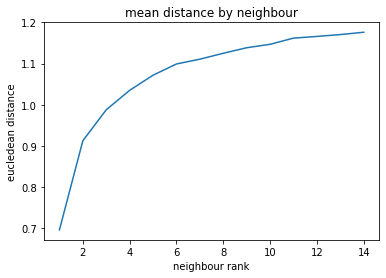

In [141]:
sns.lineplot(x=range(1,15), y=distances[:, 1:15].mean(axis=0))
plt.title("mean distance by neighbour")
plt.xlabel("neighbour rank")
plt.ylabel("eucledean distance");

In [ ]:
# upper threshold estimation
distances[:,1].std() * 2 + distances[:,1].mean()

1.5771587434044303

## Summary
Using VGG16 as a base model with one layer of embedding and 10 epochs training we achieved f1-score of 0.51.<br>
ResNet50 based model gave f1-score of 0.4. <br>

## Text Similarity
Using SquenceMatcher from string library to define similarities between two titles. Then applying the same approch of lower and upper thresholds to find matches.

## Text Preparations
Removing punctuations and lowering.

In [52]:
X['title'] = X['title'].replace(string.punctuation, '').str.lower()

## Text Similarities
Using SequenceMatcher to define similarity between each two pairs of titles.

In [53]:
def get_similarity(s1, s2):
    return SequenceMatcher(None, s1, s2).ratio()

In [54]:
text_similarities = np.empty((len(X), len(X)))

for i in tqdm(range(len(X))):
  title = X.iloc[i]['title']
  text_similarities[i] = X.title.apply(lambda x: 1 - get_similarity(title, x))

In [55]:
text_similarities_dir = '/content/drive/MyDrive/ITC/final_project/Shopee/data/text_similarities_0'
np.savetxt(text_similarities_dir, text_similarities, delimiter=",")

## Predict Matches by titles

In [128]:
thresh = 0.45
upper_thresh = 0.6

text_pred = []

for i in tqdm(range(len(text_similarities))):
    
    tresh_filt = text_similarities[i] < thresh
    text_pred.append(posting_ids[tresh_filt].tolist())
    
    if (tresh_filt.sum()) == 1:
      nearest_title_idx = np.argsort(text_similarities[i])[1]
      text_pred[i].append(posting_ids[nearest_title_idx])

In [129]:
# Presenting results

df = get_f1_score(text_pred, matches_true)

df.describe().round(2)

,tp,fp,fn,f1,precision,recall
count,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00
mean,1.76,0.48,1.75,0.61,0.74,0.59
std,2.19,1.00,2.71,0.39,0.41,0.41
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,0.27,0.50,0.17
50%,1.00,0.00,1.00,0.67,1.00,0.67
75%,2.00,1.00,2.00,1.00,1.00,1.00
max,17.00,14.00,21.00,1.00,1.00,1.00


## Image & Text Combined
Predictiing matches by images and text similarities combined.<br>
Logic: predict match only by image or text only if they are very similar, predict by the combined similarity.

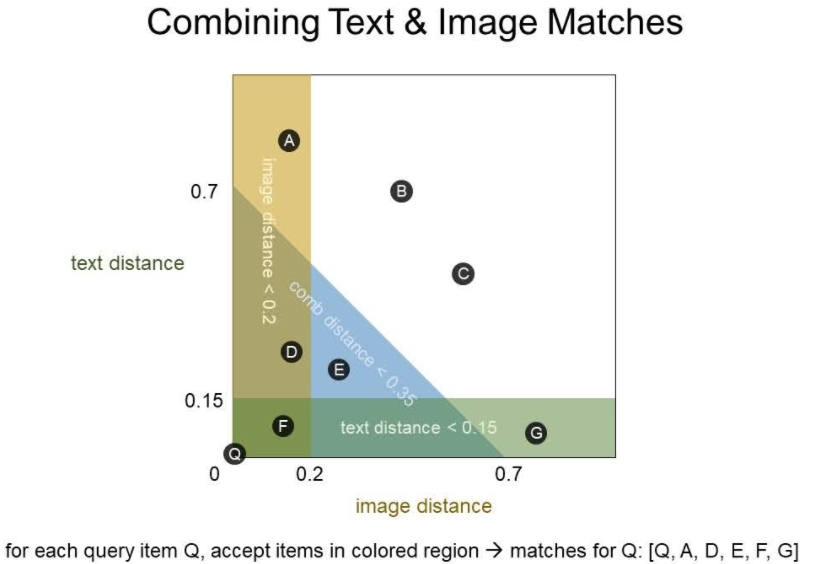

In [59]:
Image(filename='/content/drive/MyDrive/ITC/final_project/Shopee/combining text and images matches.PNG')

In [167]:
image_thresh = 0.95
text_thresh = 0.45
combined_thresh = 1.6

combined_preds = []

for i in tqdm(range(len(indices))):
    # image similarity only
    image_filt = distances[i] < image_thresh
    match_indices = indices[i, image_filt]
    combined_preds.append(posting_ids[match_indices].tolist())

    # text similarity only
    text_filt = text_similarities[i] < text_thresh
    combined_preds[i] += posting_ids[text_filt].tolist()

    # combined similarity
    combined_similarity = text_similarities[i, indices[i]] + distances[i]
    combined_filt = combined_similarity < combined_thresh
    combined_indices = indices[i, combined_filt]
    combined_preds[i] += posting_ids[combined_indices].tolist()
    
    if (len(combined_preds[i])) == 1 and (distances[i, 1] < upper_thresh):
        combined_preds[i].append(posting_ids[indices[i, 1]])

df = get_f1_score(combined_preds, matches_true)
df.describe().round(2)

,tp,fp,fn,f1,precision,recall
count,2000.00,2000.00,2000.00,2000.00,1731.00,2000.00
mean,2.51,0.59,1.00,0.71,0.87,0.74
std,2.88,1.78,2.08,0.36,0.26,0.38
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,0.50,0.91,0.50
50%,1.00,0.00,0.00,0.89,1.00,1.00
75%,3.00,0.00,1.00,1.00,1.00,1.00
max,18.00,19.00,21.00,1.00,1.00,1.00


## Error analysis

In [168]:
! unzip /content/drive/MyDrive/ITC/final_project/Shopee/data/train_images.zip

! mkdir train_images
! mv *.jpg train_images

Streaming output truncated to the last 5000 lines.
  inflating: d8fce6d90ff1c758810b2132d8d9a84e.jpg  
  inflating: d90143423d8db45b382f2dee3d01fcb1.jpg  
  inflating: d903b2ab37c0418bfeb7e6e5304b64a4.jpg  
  inflating: d905748b1f61121cdcc7ae397b97052b.jpg  
  inflating: d906df4fdf70397d4f04ef0fe6ea1fe2.jpg  
  inflating: d9074f43948053971953322ed8ddc2cf.jpg  
  inflating: d9076a1375bb05c33edd5a1f1684e1f0.jpg  
  inflating: d9093fbb00a2013aad7cbcd993d779ab.jpg  
  inflating: d90ac3ff5b7d6371c50b3ef737002084.jpg  
  inflating: d90c105714e1475c4ef930e796570749.jpg  
  inflating: d90e64bea620d6e38ffe9f35b276c192.jpg  
  inflating: d9149fbfdf8d8d197f86e0a3d2ab7584.jpg  
  inflating: d914f6199e2dbafdd4a519c48dd1a5f4.jpg  
  inflating: d9159234afcf810fa9ddc7b2d49ce707.jpg  
  inflating: d91635194d9f939a71f55373311ef611.jpg  
  inflating: d916aac02c62816e393a9caf4230604f.jpg  
  inflating: d9183402603fccd6c8cf5f2414a8ec97.jpg  
  inflating: d91b7dd96e13b18b826288e82c3ba483.jpg  
  inflating: 

In [169]:
def plot_group_images(group_id, df):
  """ plots group of images by their group label
  """
    
    plot_list = df[df['label_group'] == group_id]
    plot_list = plot_list['image'].tolist()
    images_count = len(plot_list)
    size = np.sqrt(images_count)
    if int(size)*int(size) < images_count:
        size = int(size) + 1
        
    plt.figure(figsize=(10, 7))
    
    ind=0
    for image_id in plot_list:
        plt.subplot(size, size, ind + 1)
        image = cv2.imread(f'/content/train_images/{image_id}', )
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(image_id, fontsize=6)
        plt.axis("off")
        ind+=1
    plt.show();

## False Negative Analysis
All this images represent items from the same group but they were not found to be similar by the model.

Group: 28126024


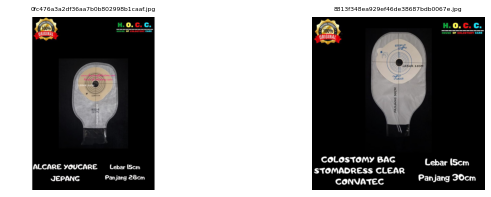

Group: 21935057


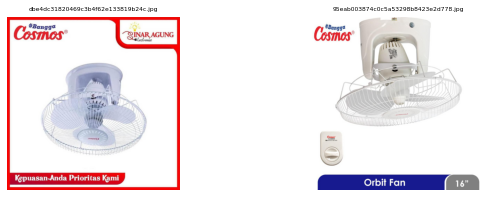

Group: 24524049


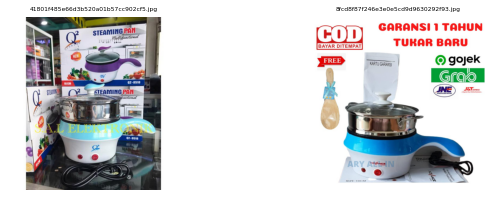

Group: 15978237


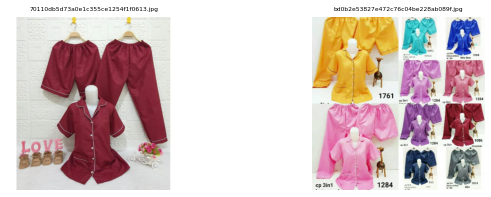

Group: 23934911


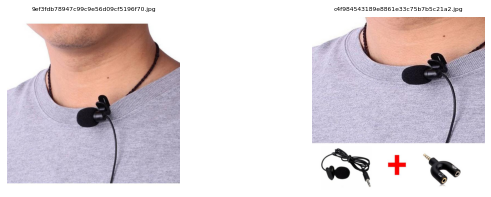

In [170]:
filt = (df.tp == 0) & (df.fn == 1)
indices = df[filt].index[:10]

for label in set(X.label_group[indices]):
  print("Group:", label)
  plot_group_images(label, X)

## Flse Positive Analysis

In [171]:
filt = (df.tp == 0) & (df.fp == 1)

fp_preds = np.array(pred)[filt]
fp_true_matches = np.array(matches_true)[filt]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [172]:
def get_image(img):
  """ return image file for given image path
  """
    image = cv2.imread(f'/content/train_images/{img}', )
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

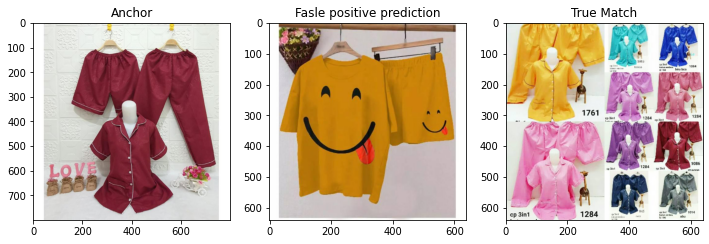

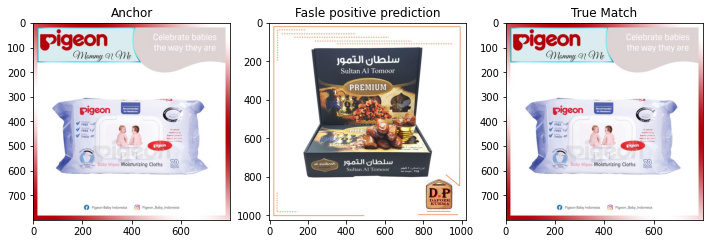

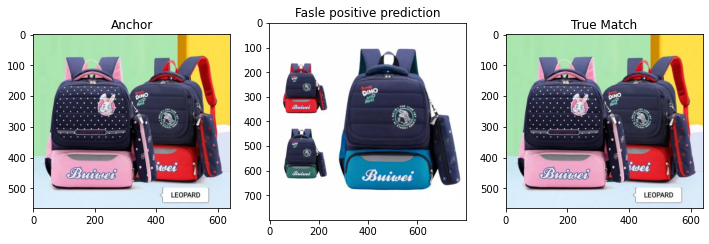

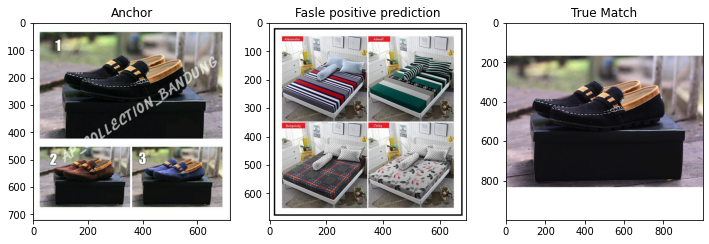

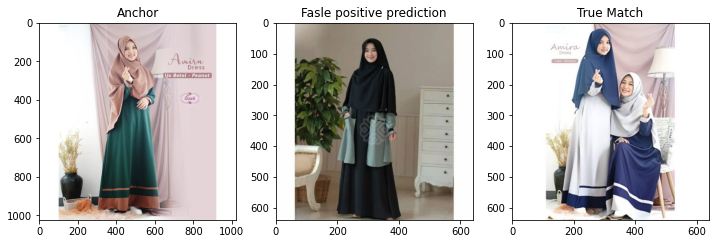

In [173]:
for i in range(5):
  fig, axs = plt.subplots(1, 3, figsize=(12,4))

  anchor_img = X.image[X.posting_id == fp_preds[i][0]].values[0]
  axs[0].imshow(get_image(anchor_img))
  axs[0].set_title("Anchor")

  pred_img = X.image[X.posting_id == fp_preds[i][1]].values[0]
  axs[1].imshow(get_image(pred_img))
  axs[1].set_title("Fasle positive prediction")

  true_match = X.image[X.posting_id == fp_true_matches[i][1]].values[0]
  axs[2].imshow(get_image(true_match))
  axs[2].set_title("True Match");

## Prediction code for deployment
to be used for single item prediction (get matches)

In [12]:
# one sample prediction (used for deployment)

from sklearn.neighbors import NearestNeighbors
import numpy as np
from numpy import genfromtxt

# path_to_dir = '/content/train_images/'
# file_path = 'vgg2.csv'
# image_embeddings_dir = '/content/drive/MyDrive/ITC/final_project/Shopee/data/siamese_image_embedding' + file_path
# X_emb_dir = '/content/drive/MyDrive/ITC/final_project/Shopee/data/siamese_data' + file_path

# img_emb = genfromtxt(image_embeddings_dir, delimiter=',')
# X = pd.read_csv(X_emb_dir)


# posting_ids = X['posting_id'].values
# thresh = 0.2
# k_neighbors = 51

X.set_index('posting_id', inplace=True)

nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='ball_tree').fit(img_emb)
distances, indices = nbrs.kneighbors(img_emb)

def predict_matches(input_posting_id, distances, indices, X):
  """ Returns matches for given posting id
  """

  input_idx = np.where(posting_ids==input_posting_id)[0][0]
  tresh_filt = distances[input_idx] < thresh
  match_indices = indices[input_idx, tresh_filt]
  matches_posting_ids = (posting_ids[match_indices].tolist())

  if tresh_filt.sum() == 1:
      matches_posting_ids.append(posting_ids[indices[i, 1]])

  matches_posting_ids.remove(input_posting_id)

  return X.loc[matches_posting_ids, :]